In [187]:
import pandas as pd
import json
import yaml
from pprint import pprint
import matplotlib.pyplot as plt
import japanize_matplotlib

In [9]:
import gspread
import pathlib

# 認証
secret_path = pathlib.Path.home() / "gcloud" / "client_secret_pojc_test.json"
gc = gspread.oauth(
    credentials_filename=secret_path, 
    authorized_user_filename="authorized_user.json", 
)


Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=115923328448-snk6uc0k6skj6j0h4vsc6k528dpg1v8b.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A62488%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fspreadsheets+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&state=JCDqegwhIWdDOp9qglwbQI3kdRiXcw&access_type=offline


In [10]:
wb = gc.open_by_key("1BPhs4nPOjcNGaOI-D2zFKAI3lBO8JtlZXBSj-dA4-Ck")
ws = wb.get_worksheet(0)

In [11]:
ws_values = ws.get_values()
df_ws = pd.DataFrame(ws_values[1:], columns=ws_values[0])

In [12]:
df_ws

,タイムスタンプ,回答者,演者,難易度,多彩性度,操作安定度,演技構成
0,2024/01/04 0:08:16,Alice,アリス,1ディアボロでは難易度の高い技をしているが、1ディアボロの技しか行っていなかった。,ボディ系の技とシンプルなインテグラルのみで幅としてはイマイチだった。,基本的に綺麗に技を行なっているが、たまにディアボロに引きずられていることがあった。,演技中のキャラ付けと曲と技の感じが良かった。
1,2024/01/04 0:08:57,Alice,チャーリー,繊細なコントロールが要求されるナンバーズのコラム・ハイトス系統が演技のほとんどを占めており、...,コラム・ハイトス系統がほとんどを占める演技であったが、様々な軌道でディアボロを動かすことで多...,よどみない操作かつミスのない演技で、非常に安定していた。ディアボロが喜んでいた。,黒を基調とした衣装のため、赤いディアボロが映えていた。序盤から2ディアボロをスタートする構成...


## 実際に投げてみる

In [17]:
import sys
import openai

sys.path.append("./src")

from judge_gpt.auth import set_apikey_from_file
from judge_gpt.tools import make_inputs_from_df

set_apikey_from_file("./openai.key")

In [19]:
client = openai.OpenAI()

In [13]:
judge_names = df_ws["回答者"].unique()
print(judge_names)

['Alice']


In [83]:
judge_name = "Alice"
comment = make_comment(df_ws.query(f"回答者 == '{judge_name}'"))

print(comment)

演者:アリス
難易度:1ディアボロでは難易度の高い技をしているが、1ディアボロの技しか行っていなかった。
多彩性度：ボディ系の技とシンプルなインテグラルのみで幅としてはイマイチだった。
操作安定度:基本的に綺麗に技を行なっているが、たまにディアボロに引きずられていることがあった。
演技構成度:演技中のキャラ付けと曲と技の感じが良かった。
演者:チャーリー
難易度:繊細なコントロールが要求されるナンバーズのコラム・ハイトス系統が演技のほとんどを占めており、極めて高難易度な演技であった。
多彩性度：コラム・ハイトス系統がほとんどを占める演技であったが、様々な軌道でディアボロを動かすことで多彩度を出せていた
操作安定度:よどみない操作かつミスのない演技で、非常に安定していた。ディアボロが喜んでいた。
演技構成度:黒を基調とした衣装のため、赤いディアボロが映えていた。序盤から2ディアボロをスタートする構成も見ごたえがあり非常に良かった。


In [176]:
prompt="""これからあなたにはジャグリングのパフォーマンスに関する評価コメントを読んでそれぞれの評価コメントを点数化してください。
コメントは難易度、多彩性度、操作安定度、新奇性度、演技構成度の5つの観点で記載されています。それぞれの観点の定義と配点は以下の通りです。
- 難易度（配点 35点）：技の要素における、難易度、数を評価する。 
- 多彩性度（配点 15点）：演技中に行った技が多彩性に富んでいたかを評価する。
- 操作安定度（配点 25点）：技の実施において、巧みさ、美しさ、洗練度合いを評価する。
- 演技構成度（配点 25点）：演技開始から演技終了までにおいて、楽曲、衣装、技の順序、起承転結などの調和性を評価する。 
これから一人の審査員のそれぞれの演者に対するコメントをもとに渡します。演者ごとに比較し順位をつけることを意識して、各項目の配点内で採点してください。"""

In [177]:
with open("tools_conf.yaml", "r") as f:
    tools = [yaml.safe_load(f)]

In [178]:
message = [
    {"role": "system", "content": prompt},
] + [
    {"role": "user", "content": comment},
]

pprint(message)

[{'content': 'これからあなたにはジャグリングのパフォーマンスに関する評価コメントを読んでそれぞれの評価コメントを点数化してください。\n'
             'コメントは難易度、多彩性度、操作安定度、新奇性度、演技構成度の5つの観点で記載されています。それぞれの観点の定義と配点は以下の通りです。\n'
             '- 難易度（配点 35点）：技の要素における、難易度、数を評価する。 \n'
             '- 多彩性度（配点 15点）：演技中に行った技が多彩性に富んでいたかを評価する。\n'
             '- 操作安定度（配点 25点）：技の実施において、巧みさ、美しさ、洗練度合いを評価する。\n'
             '- 演技構成度（配点 25点）：演技開始から演技終了までにおいて、楽曲、衣装、技の順序、起承転結などの調和性を評価する。 \n'
             'これから一人の審査員のそれぞれの演者に対するコメントをもとに渡します。演者ごとに比較し順位をつけることを意識して、各項目の配点内で採点してください。',
  'role': 'system'},
 {'content': '演者:アリス\n'
             '難易度:1ディアボロでは難易度の高い技をしているが、1ディアボロの技しか行っていなかった。\n'
             '多彩性度：ボディ系の技とシンプルなインテグラルのみで幅としてはイマイチだった。\n'
             '操作安定度:基本的に綺麗に技を行なっているが、たまにディアボロに引きずられていることがあった。\n'
             '演技構成度:演技中のキャラ付けと曲と技の感じが良かった。\n'
             '演者:チャーリー\n'
             '難易度:繊細なコントロールが要求されるナンバーズのコラム・ハイトス系統が演技のほとんどを占めており、極めて高難易度な演技であった。\n'
             '多彩性度：コラム・ハイトス系統がほとんどを占める演技であったが、様々な軌道でディアボロを動かすことで多彩度を出せていた\n'
             '操作安定度:よどみない操作かつミスの

In [179]:
res = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=message,
    tools=tools,
    tool_choice="auto",
    seed=43,
)

In [180]:
res_message = res.choices[0].message
# print(res_message)
# tool_calls = res_message.tool_calls

In [186]:
judge_result = json.loads(
    res_message.tool_calls[0].function.arguments
)

pprint(judge_result)

judge_result = pd.DataFrame(judge_result["judge_results"])

{'judge_results': [{'cleanliness': 20,
                    'desc_cleanliness': '基本的に綺麗に技を行なっているが、たまにディアボロに引きずられていることがあった。',
                    'desc_difficulty': '1ディアボロでは難易度の高い技をしているが、1ディアボロの技しか行っていなかった。',
                    'desc_program_component': '演技中のキャラ付けと曲と技の感じが良かった。',
                    'desc_variation': 'ボディ系の技とシンプルなインテグラルのみで幅としてはイマイチだった。',
                    'difficulty': 35,
                    'player_name': 'アリス',
                    'program_component': 20,
                    'variation': 5},
                   {'cleanliness': 25,
                    'desc_cleanliness': 'よどみない操作かつミスのない演技で、非常に安定していた。ディアボロが喜んでいた。',
                    'desc_difficulty': '繊細なコントロールが要求されるナンバーズのコラム・ハイトス系統が演技のほとんどを占めており、極めて高難易度な演技であった。',
                    'desc_program_component': '黒を基調とした衣装のため、赤いディアボロが映えていた。序盤から2ディアボロをスタートする構成も見ごたえがあり非常に良かった。',
                    'desc_variation': 'コラム・ハイトス系統がほとんどを占める演技であったが、様々な軌道でディアボロを動かすことで多彩度を出せていた',
                    'difficulty': 35,
         

In [183]:
judge_result["description"] = judge_result["desc_difficulty"].str.cat(
    [
        judge_result["desc_variation"], 
        judge_result["desc_cleanliness"],
        judge_result["desc_program_component"],
    ],
    sep="\n",
)

judge_result = judge_result.drop(columns=[
    col for col in judge_result.columns if col.startswith("desc_")
])


In [184]:
display(judge_result)

,player_name,difficulty,variation,cleanliness,program_component,description
0,アリス,35,5,20,20,1ディアボロでは難易度の高い技をしているが、1ディアボロの技しか行っていなかった。\nボディ...
1,チャーリー,35,13,25,25,繊細なコントロールが要求されるナンバーズのコラム・ハイトス系統が演技のほとんどを占めており、...


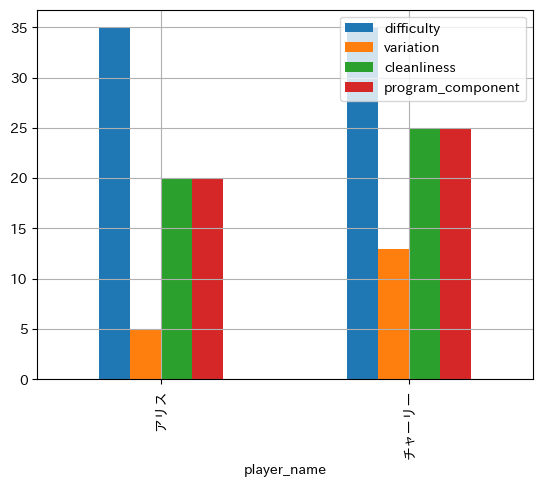

In [188]:
fig, ax = plt.subplots()

judge_result.set_index("player_name").plot(kind="bar", ax=ax)
ax.grid()